# Fit dependent Gaussian timeseries with an RNN

In [96]:
from IPython.display import Markdown

import math
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.distributions import MultivariateNormal
from torch.utils.data import DataLoader, TensorDataset

import pyro

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import colorcet as cc

import scipy
from scipy.linalg import toeplitz

If possible we train the network on the GPU.

In [2]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Generate training data: bivariate Gaussian process


In [3]:
kappa = 0.5
lamda = 1.0
rho = 1.0
mu = 1.0

sigma_ss = kappa / lamda
sigma_sx = rho * sigma_ss / (lamda + mu)
sigma_xx = rho / mu * (sigma_ss + sigma_sx)

In [4]:
def exp2(x, decay, scale):
    return scale * (-decay * x).exp()

def exprel(x):
    return torch.where(x.abs() > 1e-15, torch.special.expm1(x) / x, 1.0)

def cov_ss(t):
    return exp2(t, lamda, sigma_ss)

def cov_sx(t):
    scale1 = rho * sigma_ss * t * exprel((lamda - mu) * t)
    return exp2(t, mu, sigma_sx) + exp2(t, lamda, scale1)

def cov_xs(t):
    return exp2(t, lamda, sigma_sx)

def cov_xx(t):
    scale1 = rho * sigma_sx * t * exprel((lamda - mu) * t)
    return exp2(t, lamda, scale1) + exp2(t, mu, sigma_xx)

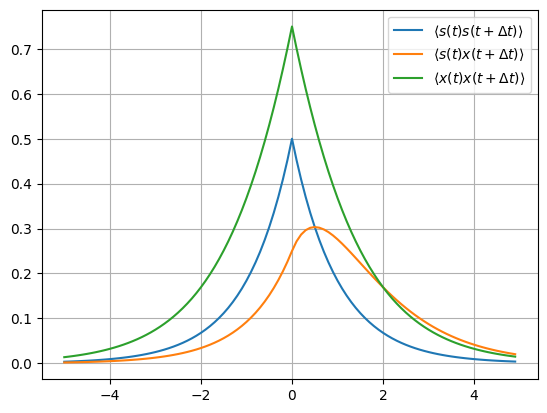

In [5]:
t = torch.arange(-5, 5, 1e-1)
plt.plot(t, cov_ss(t.abs()), label="$\\langle s(t) s(t+\Delta t)\\rangle$")
plt.plot(t, torch.where(t >= 0, cov_sx(t), cov_xs(-t)), label="$\\langle s(t) x(t+\Delta t)\\rangle$")
plt.plot(t, cov_xx(t.abs()), label="$\\langle x(t) x(t+\Delta t)\\rangle$")
plt.legend()
plt.grid();

Assemble the covariance matrix of the joint process

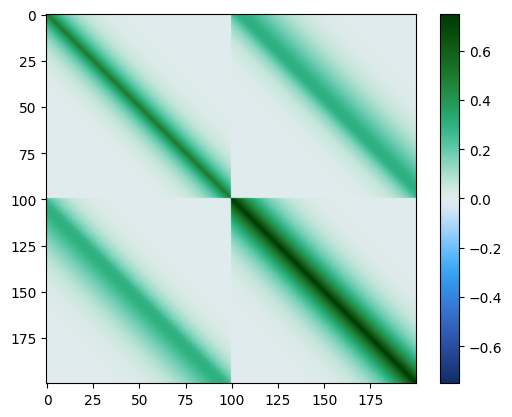

In [6]:
duration = 10.0
delta_t = 1e-1

t = torch.arange(0.0, duration, delta_t)

cov_mat_ss = toeplitz(cov_ss(t), cov_ss(t))
cov_mat_xs = toeplitz(cov_sx(t), cov_xs(t))
cov_mat_sx = toeplitz(cov_xs(t), cov_sx(t))
cov_mat_xx = toeplitz(cov_xx(t), cov_xx(t))

cov_mat_z = np.block([[cov_mat_ss, cov_mat_sx], 
                      [cov_mat_xs, cov_mat_xx]])
plt.imshow(cov_mat_z, norm=colors.CenteredNorm(), cmap=cc.m_CET_D13)
plt.colorbar()

### Prepare training data

In [7]:
cov_mat = torch.tensor(cov_mat_z)
dist = MultivariateNormal(torch.zeros(cov_mat.size(0)), cov_mat)
data = dist.sample((1000,)).reshape((-1, 2, t.size(0)))

In [8]:
val_data = dist.sample((2**9,)).reshape((-1, 2, t.size(0)))

In [9]:
data.size(), val_data.size()

(torch.Size([1000, 2, 100]), torch.Size([512, 2, 100]))

In [10]:
def make_input_and_target(data):
    s_series = data[:,0,:]
    x_series = data[:,1,:]

    # we need to shift the output by one wrt the input
    x_lagged = torch.roll(x_series, 1, dims=-1)
    x_lagged[..., 0] = 0.0

    input = torch.cat((s_series.unsqueeze(-1), x_lagged.unsqueeze(-1)), dim=-1)
    target = x_series.unsqueeze(-1)
    
    return input, target

In [11]:
input, target = make_input_and_target(data)
val_input, val_target = make_input_and_target(val_data)

input.size(), target.size(), val_input.size(), val_target.size()

(torch.Size([1000, 100, 2]),
 torch.Size([1000, 100, 1]),
 torch.Size([512, 100, 2]),
 torch.Size([512, 100, 1]))

### Visualize Training Data

In [12]:
# estimate correlation from data
def cross_corr(x, y, N=100):
    x = np.reshape(x, (-1,))
    y = np.reshape(y, (-1,))
    result = scipy.signal.correlate(y, x, 'full') / len(x)
    mid = result.shape[0]//2
    return np.arange(-N,N+1), result[mid-N:mid+N+1]

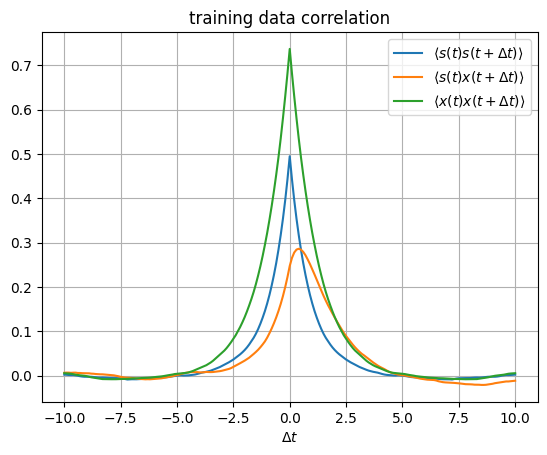

In [13]:
lags, corr_ss = cross_corr(data[:,0,:], data[:,0,:])
plt.plot(lags * delta_t, corr_ss, label="$\\langle s(t) s(t+\Delta t)\\rangle$")
lags, corr_sx = cross_corr(data[:,0,:], data[:,1,:])
plt.plot(lags * delta_t, corr_sx, label="$\\langle s(t) x(t+\Delta t)\\rangle$")
lags, corr_xx = cross_corr(data[:,1,:], data[:,1,:])
plt.plot(lags * delta_t, corr_xx, label="$\\langle x(t) x(t+\Delta t)\\rangle$")
plt.xlabel("$\Delta t$")
plt.title("training data correlation")
plt.grid()
plt.legend();

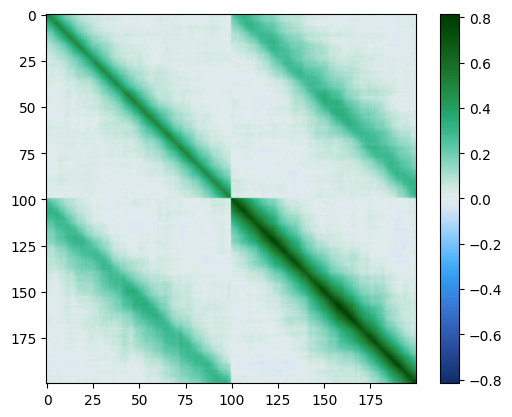

In [14]:
def plot_correlations(input, output):
    data = torch.cat((input.T, output.T), dim=0)
    plt.imshow(torch.cov(data), norm=colors.CenteredNorm(), cmap=cc.m_CET_D13)
    plt.colorbar()
    
plot_correlations(data[:,0,:], data[:,1,:])

### Gaussian Information

In [15]:
s_vec = data[:,0,:].reshape((-1,))
x_vec = data[:,1,:].reshape((-1,))
inst_cov = torch.cov(torch.stack((s_vec, x_vec)))
instantaneous_mi = 0.5 * (inst_cov.diag().log().sum() - inst_cov.logdet())
instantaneous_mi

tensor(0.0918)

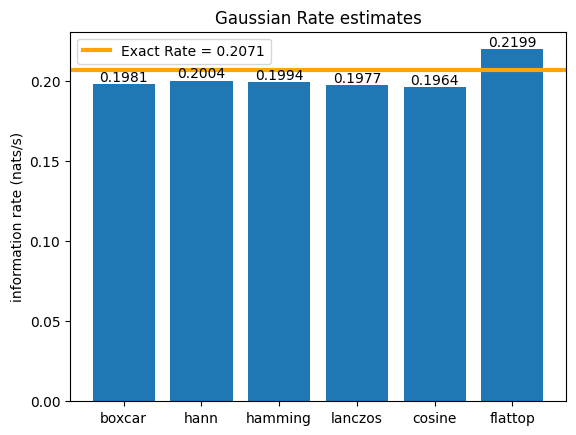

In [16]:
def tostevin_information_rate(s_data, x_data, window='hann', nfft=None):    
    freq, spectrum_ss = scipy.signal.welch(
        s_data, 
        fs=1/delta_t, 
        nperseg=s_data.shape[-1], 
        return_onesided=False, 
        detrend=False,
        window=window,
        nfft=nfft
    )
    spectrum_ss = np.mean(spectrum_ss, axis=0)

    freq, spectrum_xx = scipy.signal.welch(
        x_data, 
        fs=1/delta_t, 
        nperseg=x_data.shape[-1], 
        return_onesided=False, 
        detrend=False,
        window=window,
        nfft=nfft
    )
    spectrum_xx = np.mean(spectrum_xx, axis=0)

    freq, spectrum_sx = scipy.signal.csd(
        s_data, x_data,
        fs = 1/delta_t,
        nperseg=s_data.shape[-1],
        detrend=False,
        return_onesided=False,
        window=window,
        nfft=nfft
    )
    spectrum_sx = np.mean(spectrum_sx, axis=0)
    
    omega = 2*np.pi*freq
    
    integrand = - 1/(4*np.pi) * np.log(1 - (np.abs(spectrum_sx)**2)/(spectrum_ss * spectrum_xx))
    # plt.plot(scipy.fft.fftshift(omega), scipy.fft.fftshift(integrand))
    # plt.grid()
    val = scipy.integrate.trapezoid(scipy.fft.fftshift(integrand), x=scipy.fft.fftshift(omega))
    return float(val)

windows = ['boxcar', 'hann', 'hamming', 'lanczos', 'cosine', 'flattop']
values = []
for window in windows:
    tost = tostevin_information_rate(data[:,0,:], data[:,1,:], window=window)
    values.append(tost)
    
exact_rate = lamda/2 * (np.sqrt(1 + rho/lamda) - 1)

b = plt.bar(windows, values)
b2 = plt.axhline(exact_rate, linewidth=3, color='orange', label=f"Exact Rate = {exact_rate:.4}")

plt.title("Gaussian Rate estimates")
plt.ylabel("information rate (nats/s)")
plt.legend()
plt.bar_label(b, fmt='%.4f');

## Fitting a RNN model

### Set Hyperparameters

In [17]:
hidden_size = 8
num_layers = 1
num_batches = data.size(0)

### Define RNN model

Create a new model (called `Sequence`) based on a LSTM and a linear output layer.

In [18]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        # create an LSTM with 2 input features
        self.lstm = nn.LSTM(2, hidden_size, num_layers, batch_first=True)
        # create output layer with 2 features (mean, var)
        self.linear = nn.Linear(hidden_size+1, 2)
        
    def init_hidden(self, batches=num_batches, device=device):
        h_t = torch.zeros(num_layers, batches, hidden_size, device=device)
        c_t = torch.zeros(num_layers, batches, hidden_size, device=device)
        return h_t, c_t

    def forward(self, input, hidden):
        output, hidden = self.lstm(input, hidden)
        mean, log_var = self.linear(torch.cat((output, input[...,[0]]), dim=-1)).split(1, dim=-1)
        outputs = torch.cat((mean, log_var.exp()), dim=-1)
        return outputs, hidden

initialize the model

In [20]:
model = Sequence().to(device)
model

Sequence(
  (lstm): LSTM(2, 8, batch_first=True)
  (linear): Linear(in_features=9, out_features=2, bias=True)
)

### Train the model

We define the loss criterion and the optimizer we want to use.

In [21]:
criterion = nn.GaussianNLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Next, we define a function that does one round of training and outputs the current loss value.

The function performs the following steps:
1. **Initialization of Hidden State**:
    The hidden state of the model is initialized using the init_hidden() method.
2. **Forward Pass**:
    The input sequence (input) is passed through the model, and the output is obtained.
    The output is split into mean and variance components.
3. **Loss Computation**:
    The loss is computed using the provided criterion, which takes the mean, target, and variance as inputs. It computes the negative log likelihood of the target with respect to a Gaussian with the provided mean and variance.
4. **Backward Pass and Optimization**:
    Gradients are computed with respect to the model parameters.
    The optimizer updates the model parameters based on the computed gradients.
    Gradients are zeroed for the next iteration.

**Return**:
    The loss value for the current training iteration is returned as a float.

In [23]:
input.size()

torch.Size([1000, 100, 2])

In [24]:
dataset = TensorDataset(input, target)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True, pin_memory=True)

In [28]:
def train(dataloader):
    model.train()
    epoch_loss = 0.0
    for batch, (input, target) in enumerate(dataloader):
        # Compute prediction and loss
        hidden = model.init_hidden(input.size(0))
        output, hidden = model(input.to(device), hidden)
        mean, var = output.split(1, dim=-1)
        loss = criterion(mean, target.to(device), var)
        epoch_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return epoch_loss

def compute_loss(input, target):
    with torch.no_grad():
        hidden = model.init_hidden(input.size(0))
        output, hidden = model(input, hidden)
        mean, var = output.split(1, dim=-1)
        loss = criterion(mean, target, var)
    return loss.item()

We initialize the model.

In [29]:
train_loss = []

Then we are ready to perform the main training loop.

In [30]:
steps = 1000
for i in range(steps):
    loss = train(train_dataloader)
    train_loss.append(loss)
    step = len(train_loss)
    step % 100 == 0 and print('STEP: ', step)
    step % 100 == 0 and print('train loss:', loss)

STEP:  100
train loss: -3.9742324352264404
STEP:  200
train loss: -9.668927371501923
STEP:  300
train loss: -10.793598294258118
STEP:  400
train loss: -10.932037115097046
STEP:  500
train loss: -10.990213215351105
STEP:  600
train loss: -11.017648577690125
STEP:  700
train loss: -11.040552914142609
STEP:  800
train loss: -11.04477709531784
STEP:  900
train loss: -11.047224462032318
STEP:  1000
train loss: -11.057280361652374


After training, we can plot the losses as a function of training epochs.

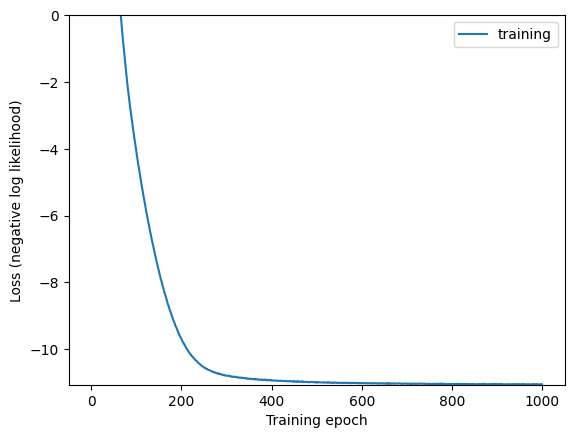

In [31]:
plt.plot(train_loss, label="training")
plt.xlabel("Training epoch")
plt.ylabel("Loss (negative log likelihood)")
plt.ylim(np.min(train_loss), 0)
plt.legend();

### Load model from file

In [246]:
# torch.save(model, "model.pth")

In [19]:
model = torch.load("model.pth").to(device)
model

Sequence(
  (lstm): LSTM(2, 8, batch_first=True)
  (linear): Linear(in_features=9, out_features=2, bias=True)
)

### Evaluate the trained model

In [20]:
# input is a (N, L) tensor where N are the number of batches and L is the length
def generate(input):
    N, L = input.size()
    model.eval()
    with torch.no_grad():
        # the first x-value we feed into the RNN is zero, consistent with the training eamples
        pred = torch.zeros((N, 1, 1), device=device)
        hidden = model.init_hidden(N)
        predictions = []
        h_n = [hidden]
        for i in range(L):
            inp = torch.cat((input[:, i].reshape((N, 1, 1)), pred), dim=-1)
            
            output, hidden = model(inp, hidden)
            pred_mean, pred_var = output.split(1, dim=-1)
            pred = torch.normal(pred_mean, pred_var.sqrt())
            
            predictions.append(pred)
            h_n.append(hidden)
        predictions = torch.cat(predictions, dim=1).squeeze(2)
        
        return predictions, h_n
        

Generate a new trajectory from the learned model.

In [21]:
eval_data, _ = generate(val_input[:,:,0].to(device))
eval_data = eval_data.cpu()
eval_data.size()

torch.Size([512, 100])

And plot its time trace

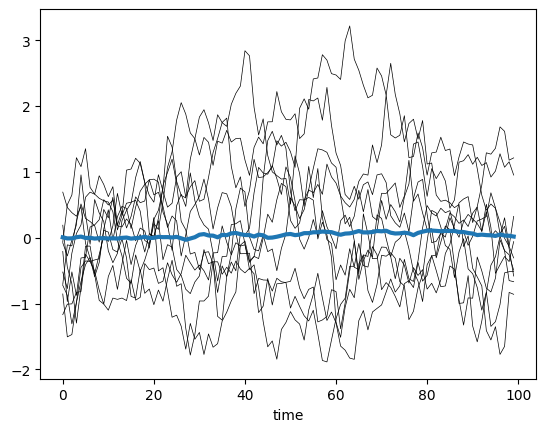

In [22]:
plt.plot(eval_data[np.arange(10), :].numpy().T, color="black", linewidth=0.5)
plt.plot(eval_data.mean(dim=0).squeeze(0), linewidth=3.0)
plt.xlabel("time");

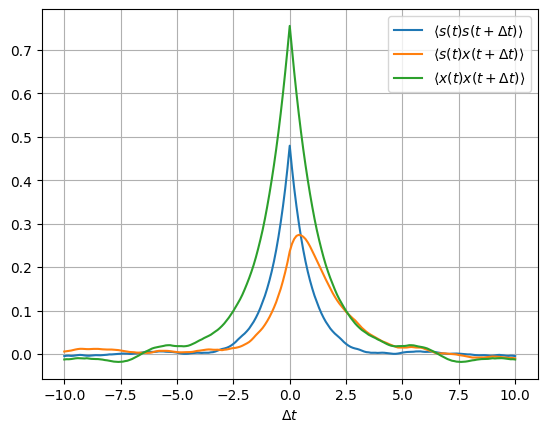

In [23]:
lags, corr_ss = cross_corr(val_input[:,:,0], val_input[:,:,0])
plt.plot(lags * delta_t, corr_ss, label="$\\langle s(t) s(t+\Delta t)\\rangle$")
lags, corr_sx = cross_corr(val_input[:,:,0], eval_data)
plt.plot(lags * delta_t, corr_sx, label="$\\langle s(t) x(t+\Delta t)\\rangle$")
lags, corr_xx = cross_corr(eval_data, eval_data)
plt.plot(lags * delta_t, corr_xx, label="$\\langle x(t) x(t+\Delta t)\\rangle$")
plt.xlabel("$\Delta t$")
plt.grid()
plt.legend();

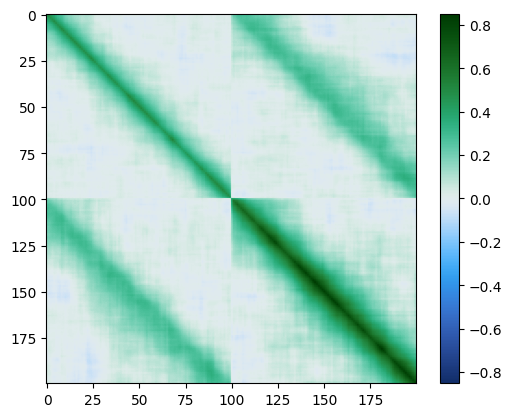

In [24]:
plot_correlations(val_input[:,:,0], eval_data)

### Visualize hidden state

In [25]:
h_tensor = torch.cat([torch.cat(h, dim=-1) for h in h_n], dim=0)

NameError: name 'h_n' is not defined

In [985]:
h_tensor.size()

torch.Size([101, 10000, 16])

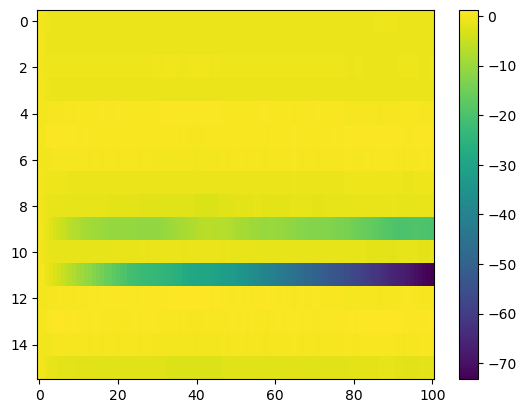

In [987]:
plt.imshow(h_tensor[:,1,:].T, aspect='auto')
plt.colorbar()

In [438]:
h_tensor.diff(dim=0)[100:150,0,:].T

tensor([], size=(16, 0))

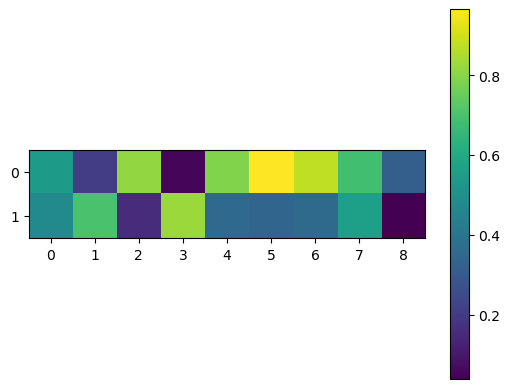

In [922]:
plt.imshow(model.linear.get_parameter("weight").detach().abs())
plt.colorbar();

## PWS

In [26]:
def log_likelihood(input, output):
    L = input.size(-1)
    
    # we need to shift the output by one wrt the input
    output_lagged = torch.roll(output, 1, dims=-1)
    output_lagged[..., 0] = 0.0
    
    model_data = torch.cat((input.unsqueeze(-1), output_lagged.expand(input.shape).unsqueeze(-1)), dim=-1)
    batch_shape = model_data.shape[:-2]
    
    flat_model_data = model_data.reshape((-1, L, 2))
    
    hidden = model.init_hidden(flat_model_data.shape[0])
    result, hidden = model(flat_model_data, hidden)
    pred_mean, pred_var = result.split(1, dim=-1)

    pred_mean = pred_mean.reshape(batch_shape + (L,)).cpu()
    pred_var = pred_var.reshape(batch_shape + (L,)).cpu()
    
    nll = F.gaussian_nll_loss(pred_mean, output.cpu(), pred_var, full=True, reduction='none')
        
    return -nll.cumsum(dim=-1)

In [27]:
def circ_indices(size):
    ind = torch.cat([torch.arange(size), torch.arange(size-1)], 0)
    return ind.as_strided((size, size), (1,1)).clone()

In [34]:
def log_evidence(input, output):
    N, L = input.size()

    tiled_input = input.tile([2, 1]).contiguous()
    
    accumulator = torch.zeros((N, L)).log()

    with torch.no_grad():
        for i in range(N):
            shifted_input = tiled_input.narrow(0, i, N)
            ll = log_likelihood(shifted_input, output).cpu()
            torch.logaddexp(accumulator, ll, out=accumulator)
    
    return accumulator - torch.log(torch.tensor(N))

In [39]:
ll = log_likelihood(data[:,0,:].to(device), data[:,1,:].to(device)).detach().cpu()
ll.size()

torch.Size([1000, 100])

In [44]:
le = log_evidence(data[:,0,:].to(device), data[:,1,:].to(device)).detach().cpu()
le.size()

torch.Size([1000, 100])

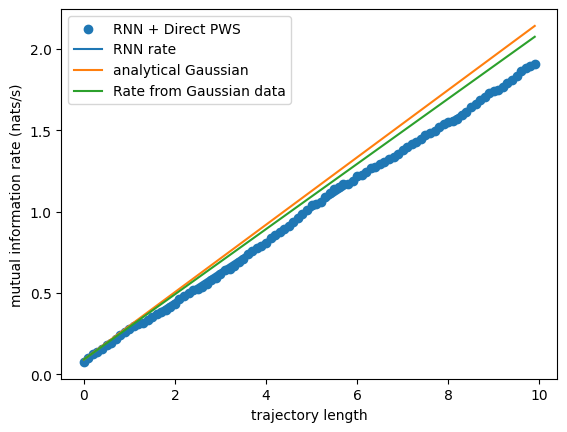

In [43]:
t = np.arange(0, duration, delta_t)
plt.scatter(t, torch.mean(ll - le, dim=0), label = "RNN + Direct PWS")

rnn_rate = torch.mean(torch.diff(torch.mean(ll - le, dim=0))[10:]).numpy() / delta_t

plt.plot(t, instantaneous_mi + t * rnn_rate, label = "RNN rate")
plt.plot(t, instantaneous_mi + t * lamda/2 * (np.sqrt(1 + rho/lamda) - 1), label = "analytical Gaussian")
plt.plot(t, instantaneous_mi + t * tostevin_information_rate(data[:,0,:], data[:,1,:]), label="Rate from Gaussian data")
plt.xlabel("trajectory length")
plt.ylabel("mutual information rate (nats/s)")
plt.legend();

## Variational Inference

In [45]:
class VariationalEncoder(nn.Module):
    def __init__(self, L):
        super(VariationalEncoder, self).__init__()
        self.linear = nn.Linear(L, L, bias=False)
        self.sigma = nn.Parameter(data=torch.eye(L))
        self.N = torch.distributions.MultivariateNormal(torch.zeros(L), torch.eye(L))
        self.log_prob = 0

    def forward(self, x, num_particles=1):
        batch_shape = ()
        if num_particles > 1:
            batch_shape = (num_particles,) + batch_shape
        mean_s = self.linear(x)
        dist = torch.distributions.MultivariateNormal(mean_s, scale_tril=self.sigma)
        s = dist.sample(batch_shape)
        self.log_prob = dist.log_prob(s)
        return s

In [391]:
var_enc = VariationalEncoder(100)
var_enc(data[:,1,:], num_particles=1).size()

torch.Size([1000, 100])

In [393]:
var_enc.log_prob.size()

torch.Size([1000])

# Pyro

The predictive model is a function that gives the likelihood of observing `data`.

In [46]:
def predictive_model(data, subsample=None):
    N, L = data.shape
    
    s_dist = pyro.distributions.MultivariateNormal(
        torch.zeros((L,), device=device), 
        torch.tensor(cov_mat_ss, device=device)
    )
    
    model.train()
    
    with pyro.plate("N", N, subsample_size=subsample) as ind:        
        s = pyro.sample("s_traj", s_dist)
        s = s.unsqueeze(-1)
        
        x = data[..., ind, :]
        
        # we need to shift the output by one wrt the input
        x_lagged = torch.roll(x, 1, dims=-1)
        x_lagged[..., 0] = 0.0
        x_lagged = x_lagged.unsqueeze(-1).expand(s.shape)
        
        model_input = torch.cat((s, x_lagged), dim=-1)
        batch_shape = model_input.shape[:-2]
        
        model_input = model_input.reshape((-1, L, 2))
        hidden = model.init_hidden(model_input.shape[0])
        
        output, hidden = model(model_input, hidden)

        pred_mean, pred_var = output.split(1, dim=-1)
        pred_mean = pred_mean.reshape(batch_shape + (L,))
        pred_var = pred_var.reshape(batch_shape + (L,))
    
        obs_dist = pyro.distributions.Normal(pred_mean, pred_var.sqrt()).to_event(1)
        
        pred = pyro.sample("pred", obs_dist, obs=x)
    
#     predictions = []
#     h_n = [hidden]
#     for i in range(L):
#         inp = torch.cat((input[..., [i]], pred), dim=-1)

#         output, hidden = model(inp, hidden)
#         pred_mean, pred_var = output.split(1, dim=-1)

#         obs = data[:, i] if data[0] is not None else None
#         with pyro.plate(f"data_loop_{i}", N):
#             pred = pyro.sample(f"pred_{i}", pyro.distributions.Normal(pred_mean[:,0,0], pred_var.sqrt()[:,0,0]), obs=obs)

#         pred = pred.reshape((N, 1, 1))
#         predictions.append(pred)
            
#     predictions = torch.cat(predictions, dim=1).squeeze(2)

    return pred
        
    

In [47]:
predictive_model(data[:,1,:].to(device)).size()

torch.Size([1000, 100])

In [210]:
conv = pyro.nn.PyroModule[nn.Conv1d](1, 1, data.size(-1), padding='same', padding_mode='circular', bias=False).to(device)
# linear.weight = pyro.nn.PyroParam(torch.eye(data.size(-1), device=device))

In [211]:
conv(data[0,1,:].unsqueeze(-2).to(device)).size()

torch.Size([1, 100])

In [212]:
def predictive_guide(data, subsample=None):
    N, L = data.shape
    
    scale = pyro.param('cov_scale', torch.tensor(1.0, device=device), constraint=pyro.distributions.constraints.positive)
    cov_ss_l = pyro.param(
        "cov_ss_l", 
        torch.eye(L, device=device), 
        constraint=pyro.distributions.constraints.unit_lower_cholesky
    )
    
    with pyro.plate("N", N, subsample_size=subsample) as ind:
        x = data[..., ind, :]
        mean_s = conv(x.unsqueeze(-2)).squeeze(-2)
        base_dist = pyro.distributions.MultivariateNormal(mean_s, scale_tril=cov_ss_l*scale)
        s_traj = pyro.sample("s_traj", base_dist)
    return s_traj

In [213]:
x_data = data[0, 1, :].expand(1024, 100)
x_data.shape

torch.Size([1024, 100])

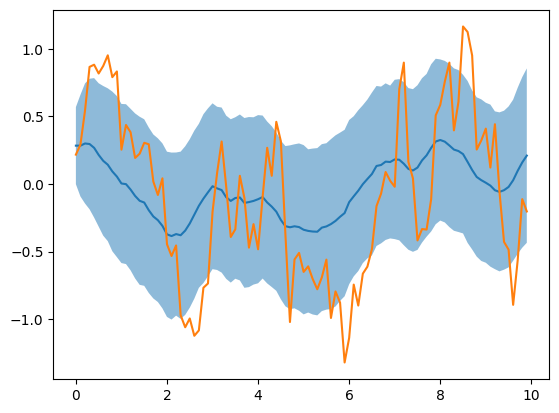

In [225]:
guide_data = predictive_guide(x_data.to(device)).detach().cpu()
plt.plot(t, guide_data.mean(dim=0))
plt.fill_between(t, guide_data.mean(dim=0) - guide_data.std(dim=0), guide_data.mean(dim=0) + guide_data.std(dim=0), alpha=.5)
plt.plot(t, x_data[0]);

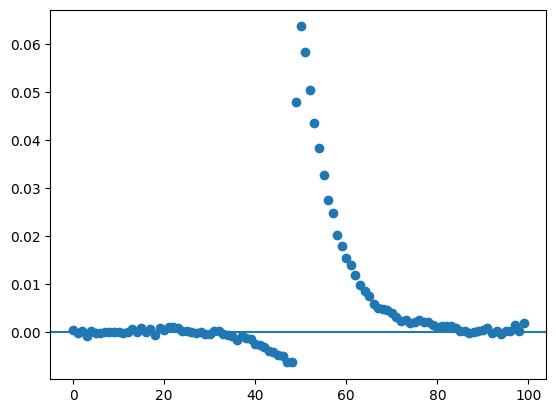

In [226]:
plt.scatter(torch.arange(100), pyro.param('weight').detach().cpu().reshape((-1,)))
plt.axhline(y=0);

In [227]:
pyro.param('cov_scale')

tensor(0.2984, device='cuda:0', grad_fn=<AddBackward0>)

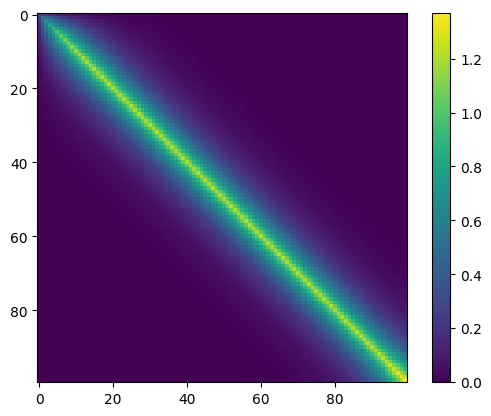

In [228]:
cov_ss_l = pyro.param("cov_ss_l").detach().cpu()
plt.imshow(torch.matmul(cov_ss_l, cov_ss_l.T) * pyro.param('cov_scale').detach().cpu())
plt.colorbar();

In [220]:
pyro.clear_param_store()
svi_losses = []

In [221]:
adam_params = {"lr": 1e-3}
optimizer = pyro.optim.Adam(adam_params)
svi = pyro.infer.SVI(
    predictive_model, 
    predictive_guide, 
    optimizer, 
    loss=pyro.infer.Trace_ELBO(num_particles=128, vectorize_particles=True)
)

In [222]:
def train_svi(svi, data):
    epoch_loss = 0.0
    epoch_loss += svi.step(data, subsample=128)
    return epoch_loss

In [223]:
n_steps = 5000
svi_data = data[:,1,:].to(device)
for step in range(n_steps):
    l = train_svi(svi, svi_data)
    svi_losses.append(l)
    (step + 1) % 100 == 0 and print(f"Finished step {step + 1}, loss={l}") #requests.post(webhook, json={"text": f"Finished step {step + 1}, loss={l}"})

Finished step 100, loss=618416.01171875
Finished step 200, loss=464797.3984375
Finished step 300, loss=361639.84765625
Finished step 400, loss=287405.3828125
Finished step 500, loss=231965.59765625
Finished step 600, loss=192432.197265625
Finished step 700, loss=162011.029296875
Finished step 800, loss=137192.0390625
Finished step 900, loss=119198.611328125
Finished step 1000, loss=102151.109375
Finished step 1100, loss=91265.4609375
Finished step 1200, loss=79462.25390625
Finished step 1300, loss=71224.921875
Finished step 1400, loss=64460.1953125
Finished step 1500, loss=58470.447265625
Finished step 1600, loss=53539.05078125
Finished step 1700, loss=49599.703125
Finished step 1800, loss=45377.11328125
Finished step 1900, loss=41916.20703125
Finished step 2000, loss=39294.421875
Finished step 2100, loss=37366.197265625
Finished step 2200, loss=35827.517578125
Finished step 2300, loss=33610.13671875
Finished step 2400, loss=32355.04296875
Finished step 2500, loss=32284.4375
Finished s

(20000.0, 80000.0)

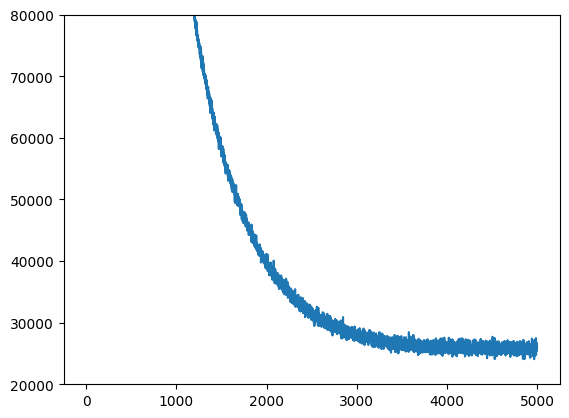

In [224]:
plt.plot(svi_losses)
plt.ylim(20000, 80000)
# plt.yscale('log');

In [182]:
importance_samples = []
importance_sampler = pyro.infer.Importance(predictive_model, guide=predictive_guide, num_samples=64)
for i in range(64):
    importance_sampler.run(svi_data)
    samples = torch.tensor(importance_sampler.log_weights)
    importance_samples.append(samples.detach().cpu())
importance_samples = torch.cat(importance_samples, 0)

In [183]:
log_p_of_x = importance_samples.logsumexp(0) - math.log(importance_samples.numel())
log_p_of_x

tensor(-25567.0840)

In [184]:
conditional_model = pyro.poutine.condition(predictive_model, data={"s_traj": data[:,0,:].to(device)})
trace= pyro.poutine.trace(conditional_model).get_trace(svi_data)
log_p_of_x_given_s = (trace.log_prob_sum() - trace.nodes['s_traj']['log_prob_sum']).detach().cpu()
log_p_of_x_given_s

tensor(-23246.3516)

In [185]:
((log_p_of_x_given_s - log_p_of_x) / data.size(0) - instantaneous_mi) / data.size(-1)

tensor(0.0223)

# Contrastive Learning

# Miscellaneous

In [5]:
import os
import requests
from dotenv import load_dotenv, find_dotenv

In [6]:
load_dotenv()

True

In [9]:
webhook = os.environ.get("SLACK_WEBHOOK")

In [327]:
payload = {"text": "training finished"}

In [1945]:
r = requests.post(webhook, json=payload)